In [46]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
%matplotlib inline


import importlib
from globals import *
import cell
import tissue
import time

importlib.reload(cell)
importlib.reload(tissue)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'tissue' from '/home/gili/weizmann/vertex_model/tissue.py'>

In [47]:
T = tissue.Tissue(cell_radius=cell_radius, num_cols=10, num_rows=10)

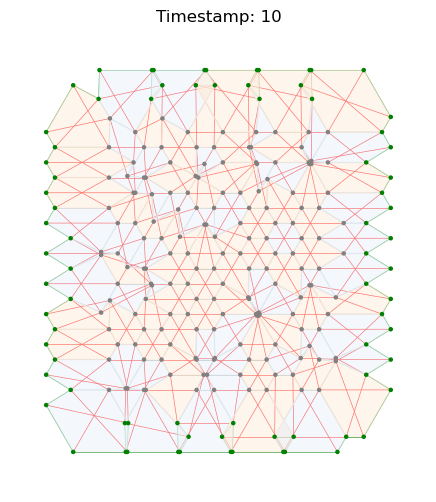

In [48]:
# add some pertubations to check plotting
# original_pos = nx.get_node_attributes(T.graph, 'pos').copy()
# for cell in T.cells:
#     cell.height = np.random.uniform(0.1, 1.0)
#     pts = np.array([original_pos[n] for n in cell.nodes])
#     center = pts.mean(axis=0)
#     for i, n in enumerate(cell.nodes):
#         x, y = original_pos[n]
#         vx, vy = x - center[0], y - center[1]
#         length = np.hypot(vx, vy) or 1.0
#         ux, uy = vx/length, vy/length
#         shift_x = np.random.normal(0, 0.2)
#         shift_y = np.random.normal(0, 0.2)
#         new_pos = (x + ux*shift_x, y + uy*shift_y)
#         T.graph.nodes[n]['pos'] = new_pos


time_limit = 10
for t in range(1, time_limit):
    # Create a new figure each time
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot tissue
    ax.set_title(f"Timestamp: {t}")
    T.plot_tissue(ax=ax)
    
    # Display the pot
    plt.tight_layout()
    display(fig)
    plt.close(fig)  # Important to avoid memory leaks
    
    # For animations in Jupyter notebooks
    clear_output(wait=True)
    time.sleep(0.5)
    
    # Update for next iteration
    T.compute_all_forces(['spring', 'line_tension'])
    T.update_positions(dt=0.5)

# Create final figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Timestamp: {time_limit}")
T.plot_tissue(ax=ax)
plt.show()


# for node in T.graph.nodes:
#     print(f"Node {node}: {T.graph.nodes[node]['force']}")